## Gaussian decomposable graphical model

Fitting a Gaussian decomposable graphical model to an auto-regressive G. 

In [1]:
SAVE_PLOTS = True
SAVE_LOC =  '/home/mo/src/decomposable_paper/img/CTA_'

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import trilearn
import trilearn.graph.junction_tree
import trilearn.graph.junction_tree as jtlib
import trilearn.graph.graph as glib
from trilearn.distributions import g_inv_wishart


import time
from scipy.interpolate import make_interp_spline
from parallelDG.graph import trajectory
import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.distributions.g_intra_class as gic
import parallelDG.auxiliary_functions as aux
from parallelDG.distributions import discrete_dec_log_linear as loglin
import parallelDG.mh_parallel as pdg
from networkx.drawing.nx_pydot import graphviz_layout
sns.set_style("whitegrid")
options = {
    "font_size": 8,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
def save_location(filename, loc = SAVE_LOC):
    if SAVE_PLOTS:
        plt.savefig(loc + filename + '.png', dpi = 600, bbox_inches='tight')
    else: 
        plt.show()
    
def smooth(x, y):
    if not x: 
        x = list(range(len(y)))
    X_Y_Spline = make_interp_spline(x, y, k=3)
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(np.min(x), np.max(x), 500)
    Y_ = X_Y_Spline(X_)
    return X_, Y_

### Simulating CTA (0.5, 0.5) Gaussian graphical model

Christmas tree algorithm

In [3]:
p = 25
n = 200
alpha = 0.5
beta = 0.5
D = np.matrix(np.identity(p))  # Scale parameter
delta = 1.0

Number of edges 60, number of nodes 25
loglikelihood 5593.877251


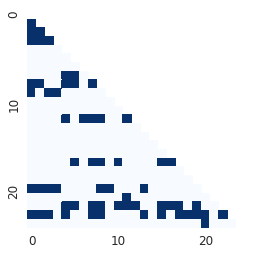

In [4]:
np.random.seed(3) # generates same data as in the paper
T = trilearn.graph.junction_tree.sample(p, alpha, beta)
G = jtlib.graph(T)
cov_mat = g_inv_wishart.sample(G, p, D)
cta_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(p), cov_mat, n))
aux.plot_heatmap(nx.to_numpy_array(G), xticklabels=10, yticklabels=10)
#nx.draw(G, with_labels=True)
print('Number of edges {}, number of nodes {}'.format(G.size(), G.order()))
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=cta_df,
                                                         graph=G,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))
save_location('ggm_true_graph_adj')

No. Edges 60


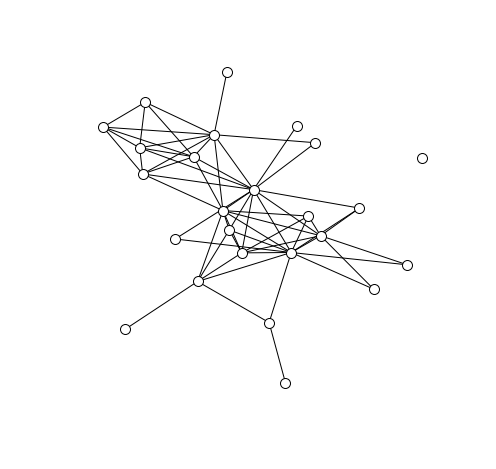

In [5]:
# Graph
plt.figure(figsize=(8,8))
pos = graphviz_layout(G, prog="fdp",)
nx.draw_networkx(G,pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
save_location('ggm_true_graph')
print('No. Edges {}'.format(G.number_of_edges()))

# Inference

## Parallel Metropolis-Hasting Junction-domain sampler

In [29]:
n_samples = 50000
randomize  = 100
graph_prior = ['jumppenalty', 1.0]
delta = 1.0
burnin = 20000
seed = 5

In [37]:
%%time
traj = pdg.sample_trajectory_ggm(dataframe=cta_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed, 
                                 parallel=True)
toc = time.time()



Metropolis-Hastings - parallel moves: 100%|██████████| 49999/49999 [00:15<00:00, 3184.78it/s]


Total of 164983 updates, for an average of 3.30 per iteration or 10505.82updates/sec
Acceptance rate 0.4256
CPU times: user 29.3 s, sys: 42.3 s, total: 1min 11s
Wall time: 15.9 s


In [38]:
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=cta_df,
                                                         graph=G,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))

loglikelihood 5593.877251


mcmc_index


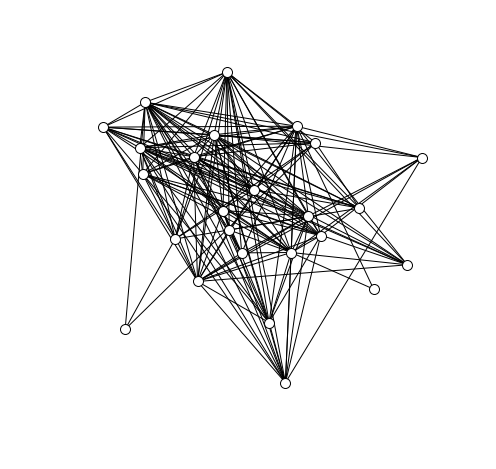

In [39]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(traj.maximum_likelihood_graph(),pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

## Log-likeihood trace plot

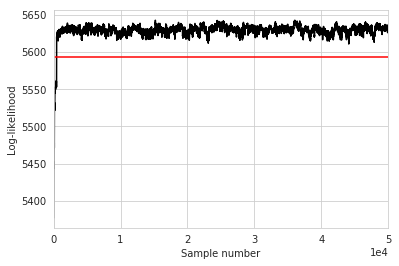

In [40]:
traj.log_likelihood().plot(color='black')
true_loglike= pdg.ggm_loglikelihood(dataframe=cta_df, 
                      graph=G,graph_prior=['uniform'],
                      delta=delta)
plt.axhline(y=true_loglike, 
            color='r', linestyle='-')  # Add a horizontal line at y=0
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
#plt.ylim((0, 1000))
save_location('ggm_loglikelihood_traceplot')

### Graph number of edges

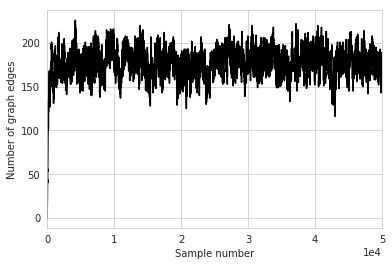

In [41]:
#traj._size=None
#traj.graph_updates = None
#traj.set_graph_trajectories()
traj.size().plot(color = 'black')
size_mcmc_index = list(traj._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
#plt.ylim((0, 4000))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_size_traceplot')


### Progressive Acceptance ratio

In [42]:
%%time
## by mcmc index and subindex
## of the graph
#traj.graph_updates = None
#traj.set_graph_trajectories(index_type = 'mcmc_index')
acc_mcmc_index = aux.acceptance_ratio(traj.trajectory)
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_subindex')
traj._size = None
traj.size()
size_mcmc_subindex = list(traj._size)
acc_mcmc_subindex = aux.acceptance_ratio(traj.trajectory)
## of the juncion tree
up = [0] * (traj.n_updates+1)
for x in traj.jt_updates: 
    up[x[1]] = 1
acc_jt_mcmc_subindex = np.mean(up, dtype=float), np.cumsum(up, dtype=float)/(np.array(range(len(up))) + 1.0)
print('Acceptance ratio  of junction tree updates {:2f}'.format(acc_jt_mcmc_subindex[0]))

Acceptance ratio 0.375368
mcmc_subindex
Acceptance ratio 0.153477
Acceptance ratio  of junction tree updates 0.425641
CPU times: user 1min 6s, sys: 1.04 s, total: 1min 7s
Wall time: 1min 7s


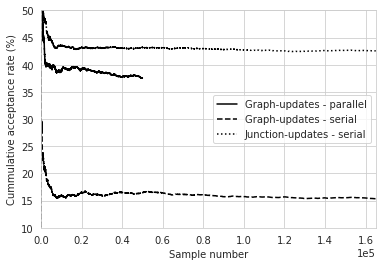

In [43]:
x = list(range(len(acc_mcmc_subindex[1])))
y = acc_mcmc_subindex[1]  * 100
z = acc_mcmc_index[1] * 100
u = acc_jt_mcmc_subindex[1] * 100
plt.plot(list(range(len(z))), z, color='black', label='Graph-updates - parallel')
plt.plot(x, y, color='black', label='Graph-updates - serial', ls='--')
plt.plot(list(range(len(u))), u, color='black', label='Junction-updates - serial', ls = ':')
plt.ylim((10, 50))
plt.xlim((0, max(x)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

### Autocorrelation plot

CPU times: user 3.82 s, sys: 588 ms, total: 4.41 s
Wall time: 3.54 s


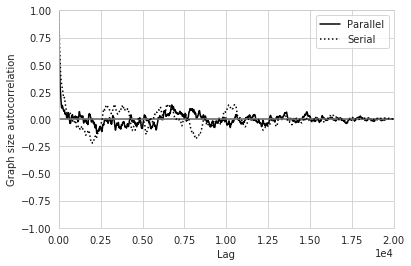

In [44]:
%%time
## Auto correlalation plot 
lag=20000
df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:]})
aux.autocorrelation_plot(df['mcmc_index'], label = 'Parallel', color = 'black', lag =lag)
aux.autocorrelation_plot(df['mcmc_subindex'], 
                                 label = 'Serial',
                                 color = 'black',
                                    ls = ':', lag = lag)
plt.legend()
plt.ylabel('Graph size autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_autocorrelation')
#plt.show()

### Maximum A Posteriori Graph

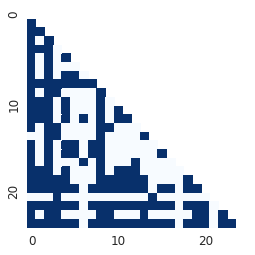

In [45]:
aux.plot_heatmap(nx.to_numpy_array(traj.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)
save_location('ggm_est_map_graph')

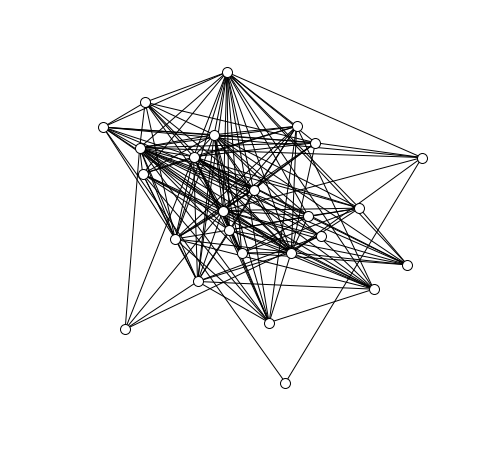

In [46]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(traj.maximum_likelihood_graph(),pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

### Trace plot heatmap

In [47]:
emp=traj.empirical_distribution(burnin).heatmap()

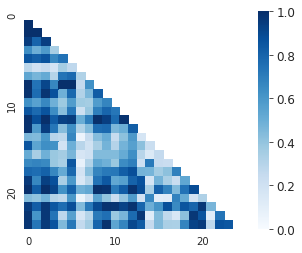

In [48]:
sns.set_style("whitegrid")
aux.plot_heatmap(emp, xticklabels=10, yticklabels=10 ,cbar = True)
save_location('ggm_est_heatmap')

### Most sampled graph

In [49]:
most_sampled = aux.most_sampled_graph(traj.trajectory[burnin:])
most_sampled

{'count': 115.0, 'g': <networkx.classes.graph.Graph at 0x7f926e0bac50>}

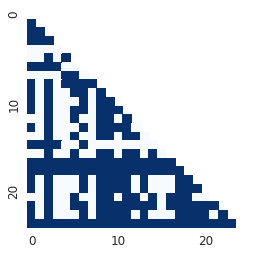

In [50]:
aux.plot_heatmap(nx.to_numpy_array(most_sampled['g']), xticklabels=10, yticklabels=10)
save_location('ggm_est_most_sampled_graph')

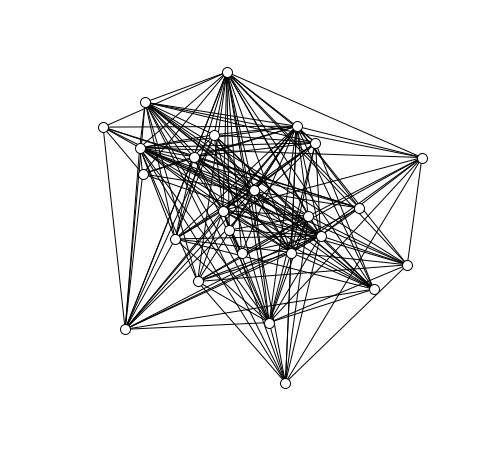

In [51]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(most_sampled['g'],pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()



# Single-partition sampler

In [52]:
%%time
n_samples = 500000
randomize  = 100
graph_prior = ['jumppenalty', 1.0]
delta = 1.0
burnin = 300000
sns.set_style("whitegrid")
tic = time.time()
seed = 2
traj_single = pdg.sample_trajectory_ggm(dataframe=cta_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed,
                                 parallel = False)

Metropolis-Hastings - single-move: 100%|██████████| 499999/499999 [01:11<00:00, 7027.40it/s] 

Total of 500000 updates, for an average of 1.00 per iteration or 7025.48updates/sec
Acceptance rate 0.4277
CPU times: user 1min 34s, sys: 1min 15s, total: 2min 50s
Wall time: 1min 11s


CPU times: user 3.57 s, sys: 594 ms, total: 4.16 s
Wall time: 3.36 s


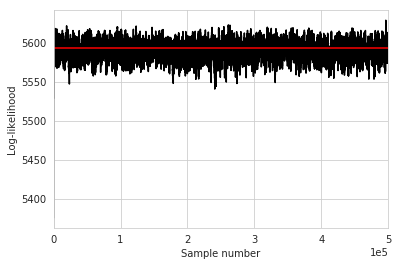

In [53]:
%%time
# Loglikelihood  trace plot
traj_single.log_likelihood().plot(color='black')
true_loglike= pdg.ggm_loglikelihood(dataframe=cta_df, 
                      graph=G,graph_prior=['uniform'],
                      delta=delta)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.axhline(y=true_loglike, 
            color='r', linestyle='-')  # Add a horizontal line at y=0
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
#plt.ylim((800,1600))
save_location('ggm_loglikelihood_traceplot_single_move')





mcmc_index
CPU times: user 2min 48s, sys: 6.1 s, total: 2min 54s
Wall time: 2min 58s


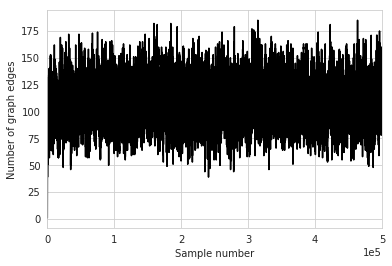

In [54]:
%%time
#traj_single._size=None
#traj_single.graph_updates = None
traj_single.set_graph_trajectories(index_type = 'mcmc_index')
traj_single.size().plot(color = 'black')
single_move_size_mcmc_index = list(traj_single._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
#plt.ylim((50,250))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_size_traceplot_single_move')            


CPU times: user 150 ms, sys: 15.4 ms, total: 165 ms
Wall time: 163 ms


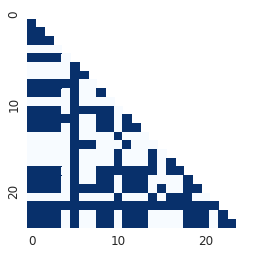

In [55]:
%%time
aux.plot_heatmap(nx.to_numpy_array(traj_single.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)
#save_location('ggm_est_map_graph')

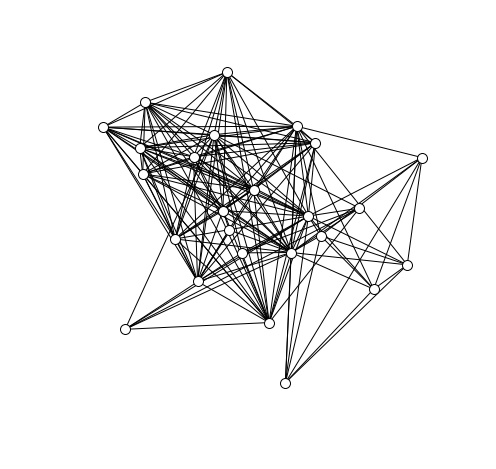

In [56]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(traj_single.maximum_likelihood_graph(),pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [57]:
%%time
## by mcmc index and subindex
## of the graph
#traj_single.graph_updates = None
#traj_single.set_graph_trajectories(index_type = 'mcmc_index')
acc_single_move_mcmc_index = aux.acceptance_ratio(traj_single.trajectory)

Acceptance ratio 0.277943
CPU times: user 1min, sys: 209 ms, total: 1min
Wall time: 1min


CPU times: user 1.84 s, sys: 526 ms, total: 2.36 s
Wall time: 1.7 s


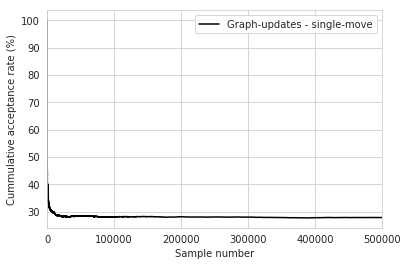

In [59]:
%%time
## plottting acceptance ratio
f = acc_single_move_mcmc_index[1] * 100
plt.plot(list(range(len(f))), f, color='black', label='Graph-updates - single-move')
#plt.ylim((0, 40))
plt.xlim((0, len(f)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
save_location('ggm_acceptance_ratio_single_move')

CPU times: user 261 ms, sys: 165 µs, total: 261 ms
Wall time: 261 ms


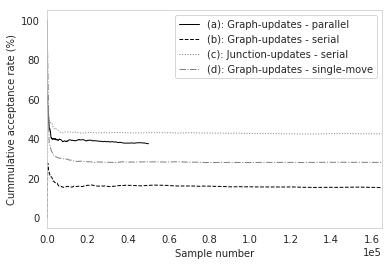

In [62]:
%%time
## Plotting joint acceptance ratio
x, y = smooth(x = None,y = acc_mcmc_subindex[1]  * 100)
xz, z = smooth(None,acc_mcmc_index[1] * 100 )
xu, u = smooth(None, acc_jt_mcmc_subindex[1] * 100)
xff, ff = smooth(None, f)

#x = list(range(len(acc_mcmc_subindex[1])))
#y = acc_mcmc_subindex[1]  * 100
#z = acc_mcmc_index[1] * 100
#u = acc_jt_mcmc_subindex[1] * 100
lw = 1
ax = plt.plot(xz, z, color='black', label='(a): Graph-updates - parallel',lw = lw)
plt.plot(x, y, color='black', label='(b): Graph-updates - serial', ls='--', lw = lw)
plt.plot(xu, u, color='grey', label='(c): Junction-updates - serial', ls = ':', lw=lw)
plt.plot(xff, ff, color='grey',label='(d): Graph-updates - single-move', ls = '-.', lw=lw)
#plt.ylim((0, 20))
plt.xlim((0, max(x)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#plt.annotate('(d)', xy=(650000,2))
#plt.annotate('(b)', xy=(550000,3.6))
#plt.annotate('(a)', xy=(80000,11))
#plt.annotate('(c)', xy=(80000,15))
plt.grid(False)
#save_location('ggm_acceptance_ratio_all')

### Autocorrelation plot

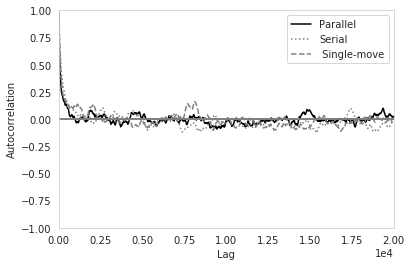

In [73]:
## Auto correlalation plot 
burnin = 50000
lag = 20000
df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:],
                    'mcmc_index_single_move': single_move_size_mcmc_index[-burnin:]})
aux.autocorrelation_plot(df['mcmc_index'], label = 'Parallel', color = 'black', lag = lag)
aux.autocorrelation_plot(df['mcmc_subindex'], 
                                 label = 'Serial',
                                 color = 'grey',
                                    ls = ':', lag = lag)
aux.autocorrelation_plot(df['mcmc_index_single_move'], 
                                 label = ' Single-move',
                                 color = 'grey',
                                    ls = '--', lag = lag)
plt.legend()
plt.ylabel('Autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_autocorrelation')